### To do: 

- include a more complex smb forcing (pdd)
- include saliency / atribute maps from gradients
- Design a new experiment where I reconstruct temperature and precipitiation, evolution maps (screenshots) during deglaciation.
- Use observed glacier extent from the years in the inversion problem. Try to reconstruct the climate


In [1]:
# Import the necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
from torch.utils.checkpoint import checkpoint
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

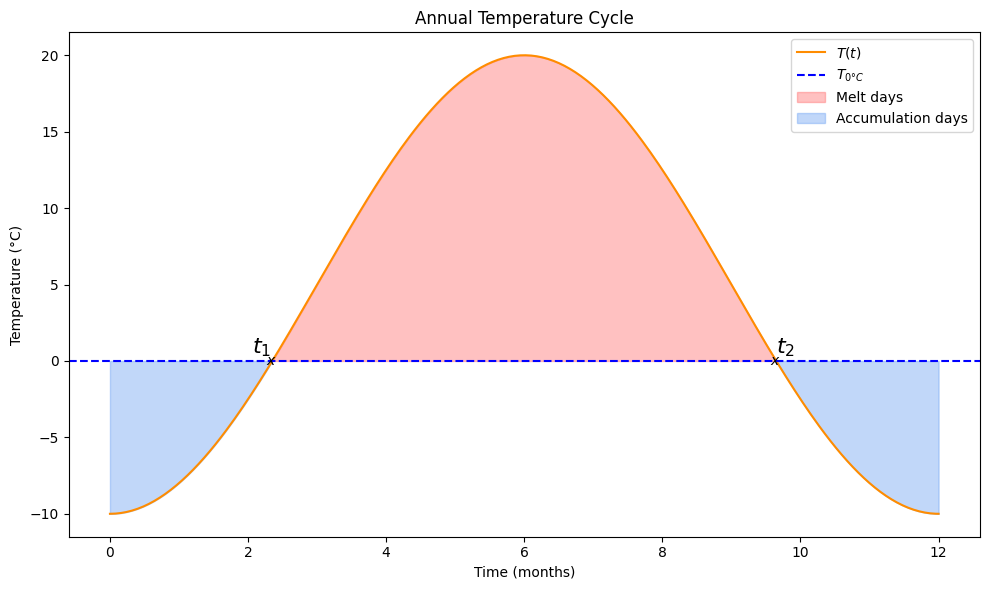

the integral is :  90.50938584758993


In [2]:
# Constants
T_ma = 5    # Mean annual temperature in degrees Celsius
T_mj = 20   # Temperature in the hottest month in degrees Celsius
A = 12      # Period in months (one year)

# Time array: monthly resolution for a full year
t = np.linspace(0, A, 300)

# Temperature function
T_abl = T_ma - (T_mj - T_ma) * np.cos(2 * np.pi * t / A)

# Compute t1 and t2
t1 = (A / (2 * np.pi)) * np.arccos(T_ma / (T_mj - T_ma))
t2 = A - t1

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, T_abl, label=r'$T(t)$', color='darkorange')
plt.axhline(y=0, color='blue', linestyle='--', label=r'$T_{0°C}$')

# Fill area under curve between t1 and t2
mask_red = (t >= t1) & (t <= t2)
plt.fill_between(t, T_abl, 0, where=mask_red, interpolate=True, color='#FF6464', alpha=0.4, label='Melt days')

# Fill area between curve and T=0 for t in [0, t1]
mask_blue1 = (t >= 0) & (t <= t1)
plt.fill_between(t, T_abl, 0, where=mask_blue1, interpolate=True, color='#659DF2', alpha=0.4, label='Accumulation days')
mask_blue2 = (t >= t2) & (t <= A)
plt.fill_between(t, T_abl, 0, where=mask_blue2, interpolate=True, color='#659DF2', alpha=0.4)


# Annotations
plt.text(t1 - 0.3, 0.5, r'$t_1$', color='black', fontsize=16)
plt.text(t2, 0.5, r'$t_2$', color='black', fontsize=16)
plt.text(t1 - 0.09, -0.25, r'$x$', color='black', fontsize=10)
plt.text(t2 - 0.09, -0.25, r'$x$', color='black', fontsize=10)

# Title and labels
plt.title('Annual Temperature Cycle')
plt.xlabel('Time (months)')
plt.ylabel('Temperature (°C)')
plt.legend()
# plt.grid(True)
plt.tight_layout()
plt.savefig('annual_temp.png')
plt.show()

ratio= T_ma / (T_mj - T_ma)
integral = (
            T_ma * (A - (A / np.pi) * np.arccos(ratio)) +
            ((T_mj - T_ma) * A / np.pi) * np.sqrt(1 - ratio**2))
print("the integral is : ",integral)


In [3]:
def compute_integral_positive_temperature(T_ma, T_mj):
    """
    Computes the integral of T_abl(t) over the period where T_abl > 0 (PyTorch version).
    """
    A = 12.0  # months
    ratio = T_ma / (T_mj - T_ma)
    integral = torch.zeros_like(T_ma)

    valid = ratio < 1
    ratio_valid = torch.clamp(ratio[valid], -1.0, 1.0)

    integral[valid] = (
        T_ma[valid] * (A - (A / torch.pi) * torch.acos(ratio_valid)) +
        ((T_mj[valid] - T_ma[valid]) * A / torch.pi) * torch.sqrt(1 - ratio_valid**2)
    )

    return integral

def apply_lapse_rate(topography, T_ma_lowest, T_mj_lowest):
    lapse_rate = 7.0 / 1000.0  # 6°C/km
    min_altitude = torch.min(topography)
    delta_alt = topography - min_altitude

    T_ma = T_ma_lowest - lapse_rate * delta_alt
    T_mj = T_mj_lowest - lapse_rate * delta_alt

    return T_ma, T_mj

def compute_negative_temperature_ratio(T_ma, T_mj):
    """
    Computes the ratio of the year when the temperature is negative (PyTorch version).
    Parameters:
        T_ma (Tensor): 2D tensor of mean annual temperatures (on device)
        T_mj (Tensor): 2D tensor of hottest month temperatures (on device)
    Returns:
        Tensor: 2D tensor of negative temperature ratios (values between 0 and 1)
    """
    ratio = T_ma / (T_mj - T_ma)
    neg_temp_ratio = torch.zeros_like(T_ma)
    # Case 1: Always positive temp
    mask_always_positive = ratio >= 1
    neg_temp_ratio[mask_always_positive] = 0.0
    # Case 2: Always negative temperatures
    mask_always_negative = ratio <= -1
    neg_temp_ratio[mask_always_negative] = 1.0
    # Case 3: Valid
    mask_valid = (~mask_always_positive) & (~mask_always_negative)
    ratio_valid = torch.clamp(ratio[mask_valid], -1.0, 1.0)
    neg_temp_ratio[mask_valid] = (1.0 / torch.pi) * torch.acos(ratio_valid)

    return neg_temp_ratio


In [4]:
# Define SMB parameters directly
melt_f =2/12 # m water / (C year)
smb_oggm_wat_density = 1000.0
smb_oggm_ice_density = 910.0  #kg/m^3
def update_smb(Z_topo,precipitation, T_ma_lowest,T_mj_lowest):
    """Compute the surface mass balance (SMB)
         Input:  precipitation [Unit: m * y^(-1)]
                 air_temp      [Unit: °C           ]
         Output  smb           [Unit: m ice eq. / y]
    This mass balance routine implements the surface mass balance model of OGGM
    """

    T_ma, T_mj = apply_lapse_rate(Z_topo, T_ma_lowest, T_mj_lowest)
    
    # Compute accumulation

    accumulation= precipitation* compute_negative_temperature_ratio(T_ma, T_mj) # unit: [ m * y^(-1) water ]
    

    # Compute ablation
    ablation = melt_f  *  compute_integral_positive_temperature(T_ma, T_mj)# unit: [m water / (C year)] * [C year]  => m water 
    # Compute SMB and convert to ice equivalent
    smb = (accumulation - ablation).sum(dim=0) * (smb_oggm_wat_density / smb_oggm_ice_density)
    
    return smb

In [5]:
precip = 1.5 # e.g., m/year
T_ma_lowest = 7 # °C at lowest elevation
T_mj_lowest = 17  # °C at lowest elevation

nc_file = netCDF4.Dataset('../../bedrock_200m.nc')
# nc_file = netCDF4.Dataset('AIF-v1/output-500.nc')
Z_topo = torch.tensor(nc_file.variables['topg'][:], device=device)

# Constant precipitation
precip_tensor = torch.full((1,*Z_topo.shape), precip, device=device)


smb = update_smb(Z_topo,precip_tensor,T_ma_lowest,T_mj_lowest)
torch.save(smb,'smb2.pt')

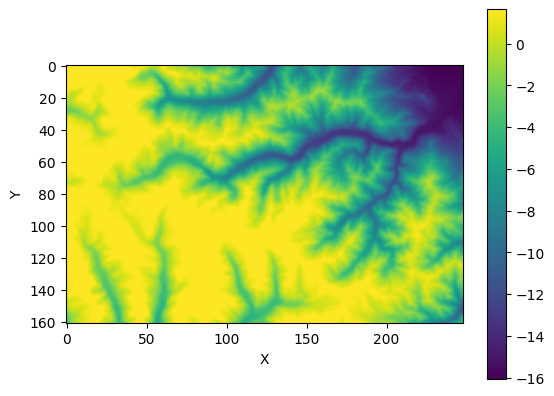

In [6]:
smb_npy = (smb).to(torch.float32).detach().cpu().numpy()

plt.imshow(smb_npy)
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar()
plt.show()

In [7]:
smb_npy.max()

1.6483517

In [8]:
# Prepare hooks for tensors 
def print_hook_b(grad):
    print("\n Gradient is :", torch.norm(grad))
    return grad

def reduce_hook(grad):
    return grad * 1/5

def increase_hook(grad):
    return grad * 2

### Prepare the spatial-temporal observations

In [9]:
# nc_file = netCDF4.Dataset('../data/geology_200m.nc')
# Z_topo = torch.tensor(nc_file.variables['topg'][:], device=device)
# thk_1880 = torch.tensor(nc_file.variables['thk_1880'][:], device=device)
# ice_mask = torch.tensor(nc_file.variables['icemask'][:], device=device)

ttot = 100  # Time limit (yr)
t_start=1880.

rho, g, fd = torch.tensor([910.0, 9.81,0.25e-16], device=device) # units [kg/m^3, m/s^-2, Pa^-3year^-1]

dx=200
dy=200
Lx=Z_topo.shape[1]*dx
Ly=Z_topo.shape[0]*dy
nc_file.close()
# torch.save(thk_1880,'Obs_2D.pt')


In [10]:
# ice_mask[ice_mask<0.8]=0
# # Reshape to 4D: (batch=1, channel=1, x, y)
# ice_mask_4d = ice_mask.unsqueeze(0).unsqueeze(0)

# # Define a 3x3 kernel of ones
# kernel = torch.ones((1, 1, 3, 3), device=device)

# # Apply convolution with padding=1 to keep output size same
# smoothed = F.conv2d(ice_mask_4d, kernel, padding=1)
# # Normalize to range 0–1 (or leave as raw sum of neighbors if desired)
# smoothed_normalized = smoothed / kernel.sum()

# # Remove extra dimensions to return to (x, y)
# smoothed_mask = smoothed_normalized.squeeze()

In [11]:
# Convert to NumPy
Z_topo_npy = Z_topo.to(torch.float32).cpu().numpy()
thk_1880_npy = thk_1880.to(torch.float32).cpu().numpy()

# Define the extent: [xmin, xmax, ymin, ymax]
extent = [0, Lx/100, 0, Ly/100]
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot topography
img = ax.imshow((Z_topo_npy + thk_1880_npy)/100, cmap='terrain', origin='lower',extent=extent)

# Create divider for colorbar and reduce padding
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)  # pad controls the spacing
cbar = fig.colorbar(img, cax=cax)
cbar.set_label('Topography /100 [m]')

# Overlay glacier thickness
thk_display = np.ma.masked_where(thk_1880_npy <= 0, thk_1880_npy)
ax.imshow(thk_display, cmap='Blues', alpha=1, origin='lower',extent=extent)

# Titles and labels
ax.set_title("Aletsch Glacier (1880)")
ax.set_xlabel("X /100 [m]")
ax.set_ylabel("Y /100 [m]")
# Add the red star marker
ax.plot(40,190, marker='*', color='red', markersize=15, markeredgecolor='black')


plt.tight_layout()
plt.show()

NameError: name 'thk_1880' is not defined

In [12]:
class GlacierDynamicsCheckpointed(torch.nn.Module):
    def __init__(self, Z_topo, ttot, rho, g, fd, Lx, Ly, dx, dy, dtmax, device):
        super().__init__()
        self.Z_topo = Z_topo
        self.ttot = ttot
        # self.grad_b = grad_b
        # self.b_max = b_max
        self.rho = rho
        self.g = g
        self.fd = fd
        self.Lx = Lx
        self.Ly = Ly
        self.dx = dx
        self.dy = dy
        self.dtmax = dtmax
        self.device = device
        

    def forward(self, precip_tensor, T_ma_lowest,T_mj_lowest):
        return self.solve_glacier_dynamics(self.Z_topo, self.ttot,precip_tensor, T_ma_lowest,T_mj_lowest)

    def solve_glacier_dynamics(self, Z_topo, ttot,precip_tensor, T_ma_lowest,T_mj_lowest):
        nx = int(self.Lx / self.dx)
        ny = int(self.Ly / self.dy)

        epsilon = torch.tensor(1.e-10, device=self.device)
        H_ice = torch.zeros((ny, nx), device=self.device)
        # H_ice = H_initial.to(device=device)
        
        Z_surf = Z_topo + H_ice

        time = torch.tensor(0., device=self.device)
        # dt = torch.tensor(self.dtmax, device=self.device)
        it = torch.tensor(0., device=self.device)
        t_freq=torch.tensor(5., device=self.device)
        t_last_update=torch.tensor(0., device=self.device)
        #initial smb 
        smb = update_smb(Z_surf,precip_tensor,T_ma_lowest,T_mj_lowest)

        def checkpointed_step(H_ice, Z_surf,smb, time):
            # Compute H_avg
            H_avg = 0.25 * (H_ice[:-1, :-1] + H_ice[1:, 1:] + H_ice[:-1, 1:] + H_ice[1:, :-1])

            # Compute Snorm
            Sx = (Z_surf[:, 1:] - Z_surf[:, :-1]) / self.dx
            Sy = (Z_surf[1:, :] - Z_surf[:-1, :]) / self.dy
            Sx = 0.5 * (Sx[:-1, :] + Sx[1:, :])
            Sy = 0.5 * (Sy[:, :-1] + Sy[:, 1:])
            Snorm = torch.sqrt(Sx**2 + Sy**2 + epsilon)

               
            # Compute diffusivity
            D = (self.rho * self.g)**3.0 *(self.fd * H_avg**5 + 0.2e-12*H_avg**3)* Snorm**2 + epsilon
            

            # Compute adaptive time step.
            dt_value = min(min(self.dx, self.dy)**2 / (2.7 * torch.max(D).item()), self.dtmax)
            dt = torch.tensor(dt_value, dtype=torch.float32, device=self.device, requires_grad=True)

            # Compute fluxes
            qx = -(0.5 * (D[:-1, :] + D[1:, :])) * (Z_surf[1:-1, 1:] - Z_surf[1:-1, :-1]) / self.dx
            qy = -(0.5 * (D[:, :-1] + D[:, 1:])) * (Z_surf[1:, 1:-1] - Z_surf[:-1, 1:-1]) / self.dy

            # Compute thickness change rate
            dHdt = -(torch.diff(qx, dim=1) / self.dx + torch.diff(qy, dim=0) / self.dy)

            # Update ice thickness
            H_ice = H_ice.clone()
            H_ice[1:-1, 1:-1] = H_ice[1:-1, 1:-1] + dt * dHdt

            H_ice = H_ice.clone()
            H_ice[1:-1, 1:-1] = H_ice[1:-1, 1:-1] + dt * smb[1:-1, 1:-1]

            # Ensure ice thickness remains positive
            H_ice = torch.maximum(H_ice, torch.tensor(0.0, dtype=torch.float32, device=self.device))

            # Update surface topography
            Z_surf = Z_topo + H_ice
            return H_ice, Z_surf, time + dt

        while time < ttot:           

            H_ice, Z_surf, time = checkpoint(checkpointed_step, H_ice, Z_surf, smb, time)
            it += 1
            # Compute surface mass balance (SMB)
            if (time-t_last_update)>=t_freq:
                smb = update_smb(Z_surf,precip_tensor,T_ma_lowest,T_mj_lowest) 
                t_last_update=time.clone()
        return H_ice

# Wrap the solve_glacier_dynamics function in the checkpointed module
glacier_model = GlacierDynamicsCheckpointed(Z_topo, ttot, rho, g, fd, Lx, Ly, dx, dy, 1, device)

# Replace the direct call with a call to the checkpointed model
H_simulated = glacier_model(precip_tensor, T_ma_lowest,T_mj_lowest)
# torch.save(H_simulated,'Obs_2D.pt')

/home/klleshi/miniconda3/envs/IGEM/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/klleshi/miniconda3/envs/IGEM/lib/python3.12/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [13]:
torch.save(H_simulated,'run2.pt')

In [14]:
def visualize(Z_surf,time,H_ice):
        plt.figure(2, figsize=(11, 4), dpi=200)
        # First subplot: Ice surface
        plt.subplot(1, 2, 1)
        plt.imshow(Z_surf.cpu().numpy(), cmap='terrain', origin='lower')
        plt.colorbar(label='Elevation (m)')
        plt.title('Ice Surface at ' + str(int(time)) + ' y')
        plt.xlabel('Distance, km')
        plt.ylabel('Distance, km')
        # Second subplot: Ice thickness
        plt.subplot(1, 2, 2)
        plt.imshow(np.where(H_ice.cpu().numpy() > 0, H_ice.cpu().numpy(), np.nan), cmap='jet', origin='lower')
        plt.colorbar(label='Ice Thickness (m)')
        plt.title('Ice Thickness at ' + str(int(time)) + ' y')
        plt.xlabel('Distance, km')
        plt.ylabel('Distance, km')
        # Show the plot
        plt.show()

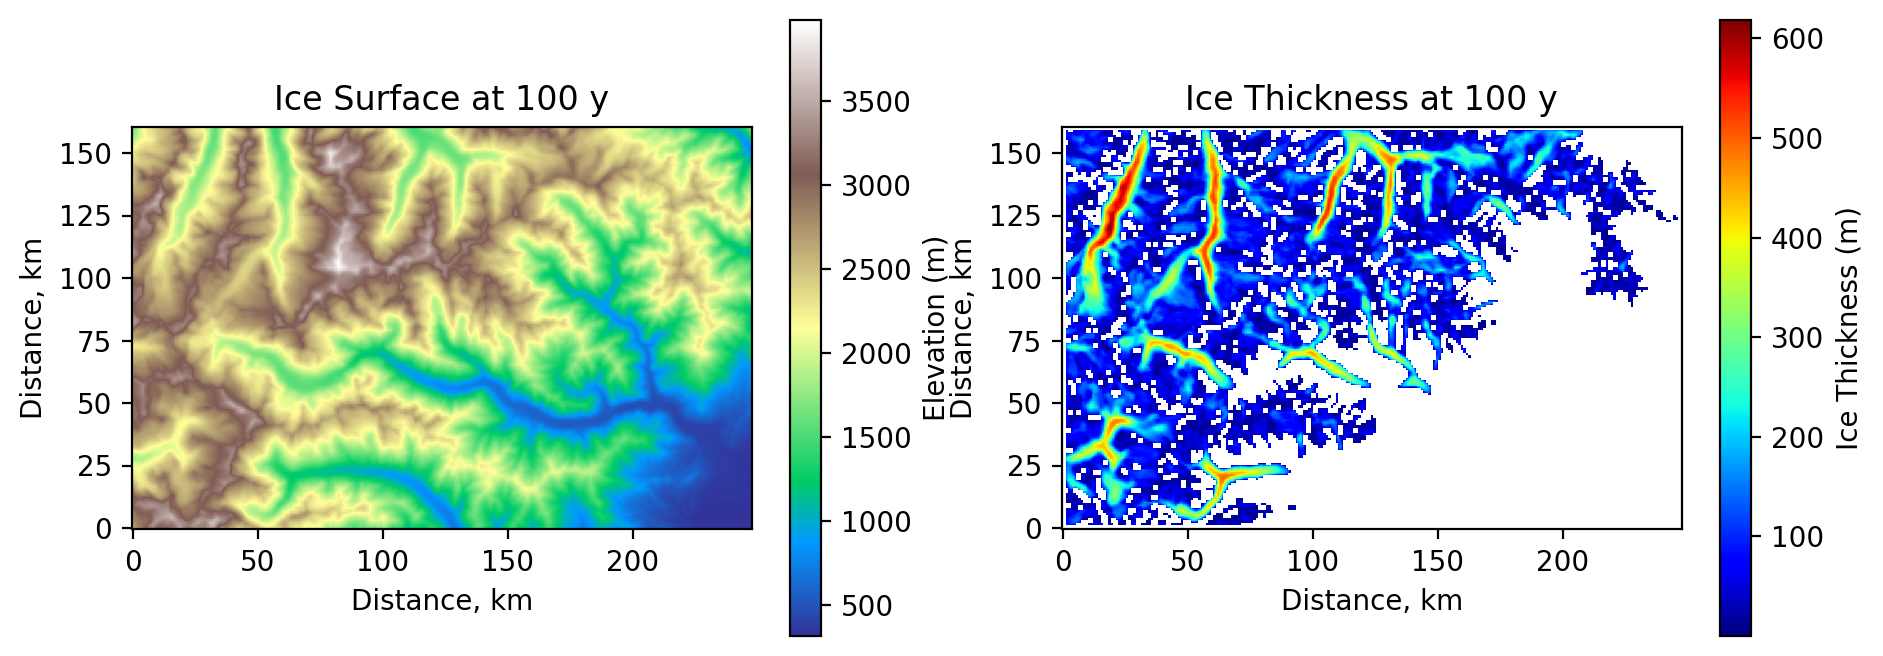

In [15]:
visualize(Z_topo,ttot,H_simulated.detach())

#### Inversion options 
**Mean Square Error (MSE)**:

* Recomended for the case where we have glacier thickness. Converges the fastest.  


**Intersection over Union (IoU)**: 

* Also known as the **Jaccard Index**, this measures the overlap between simulated and observed extents. We use this option when we do not have information about the glacier thickness.


In [16]:
# # Define a function for the forward computation to use with checkpointing
def inversion_thicknes(precip_tensor, T_ma_lowest,T_mj_lowest,observed_thk, reg_lambda):
    # Perform forward simulation
    H_simulated = glacier_model(precip_tensor, T_ma_lowest,T_mj_lowest)

    # Compute data fidelity term
    data_fidelity = torch.mean(torch.abs(H_simulated - observed_thk) ** 2)/torch.norm(observed_thk)

    # Compute smoothness regularization
    smoothness_x = torch.sum((precip_tensor[:, 1:] - precip_tensor[:, :-1]) ** 2)
    smoothness_y = torch.sum((precip_tensor[1:, :] - precip_tensor[:-1, :]) ** 2)
    smoothness_reg = smoothness_x + smoothness_y

    # Total loss
    loss = data_fidelity + reg_lambda * smoothness_reg
    return loss,H_simulated

# Define a function for the forward computation to use with checkpointing
def inversion_extent(precip_tensor,temp_low,temp_high, observed_thk):
    """
    Forward computation with IoU for data fidelity and smoothness regularization.

    Args:
        Z_ELA (torch.Tensor): The equilibrium line altitude field.
        observed_thk (torch.Tensor): The observed glacier thickness.
        reg_lambda (float): Regularization parameter for smoothness.
        threshold (float): Thickness threshold to define glacier extent.

    Returns:
        loss (torch.Tensor): Total loss including IoU and regularization.
        H_simulated (torch.Tensor): Simulated glacier thickness.
    """
    # Perform forward simulation
    H_simulated =  glacier_model(precip_tensor, T_ma_lowest,T_mj_lowest)  # Use the checkpointed glacier model
    
    # Steeper sigmoid using a scaling factor
    scale = 100.0
    mask_simulated = torch.sigmoid(scale * (H_simulated - 1))
    mask_observed = torch.sigmoid(scale * (observed_thk - 1))

    # Compute data fidelity term
    data_fidelity = torch.mean(torch.abs(mask_simulated - mask_observed) ** 2)
    # Compute smoothness regularization
    smoothness_x = torch.sum((precip_tensor[:, 1:] - precip_tensor[:, :-1]) ** 2)
    smoothness_y = torch.sum((precip_tensor[1:, :] - precip_tensor[:-1, :]) ** 2)
    smoothness_reg = smoothness_x + smoothness_y
    
    reg_lambda=0.000
    # Total loss
    loss = data_fidelity + reg_lambda * smoothness_reg

    return loss, H_simulated


In [17]:
# Reset the starting point in tracking maximum GPU memory occupied by tensors in bytes for a given device.
torch.cuda.reset_peak_memory_stats()

# Initial guesses for inversion problem
# precip_tensor = torch.full((1, *Z_topo.shape), precip, requires_grad=True, device=device)
precip_tensor = torch.load('percip.pt').to(device).requires_grad_()

# Observed glacier thickness (assumed already loaded as observed_thk tensor)
observed_thk = torch.load('Obs_2D.pt').to(device)

# Hyperparameters
initial_lr = 0.1
reg_lambda = 1
n_iterations = 5

# Optimizer setup
optimizer = torch.optim.Adam([precip_tensor], lr=initial_lr)
# optimizer = torch.optim.Adam([precip_tensor, T_ma_lowest, T_mj_lowest], lr=initial_lr)

# Tracking variables
total_loss_history = []
data_fidelity_history = []
regularization_history = []
total_gradients_history = []

# Main loop
for i in range(n_iterations):
    start_time = time.time()
    optimizer.zero_grad()
    print(f'Nb iterations: {i + 1} {50*'-'}')


    # Forward pass with gradient checkpointing
    loss, H_simulated = inversion_thicknes(precip_tensor, T_ma_lowest, T_mj_lowest, observed_thk, reg_lambda)

    # Backward pass
    loss.backward()
    # Collect gradient norms
    grad_norms = []
    for param in optimizer.param_groups[0]['params']:
        norm = torch.norm(param.grad)
        print(f'Gradient norm of parameter: {norm:.4f}')

    # Optimizer step
    optimizer.step()

    # Log timing
    elapsed_time = time.time() - start_time
    print(f"Iteration {i + 1} took {elapsed_time:.2f} seconds. precip mean = {precip_tensor.mean().item():.3f}")
    # Store history
    total_loss_history.append(loss.item())
    total_gradients_history.append(torch.norm(precip_tensor.grad).item())

    with torch.no_grad():
        # visualize(precip_tensor[0],i,H_simulated,Lx,Ly)
        data_fidelity = torch.mean((H_simulated - observed_thk) ** 2).item()
        data_fidelity_history.append(data_fidelity)
        print(data_fidelity)



/tmp/ipykernel_8908/381496516.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  precip_tensor = torch.load('percip.pt').to(device).requires_grad_()


FileNotFoundError: [Errno 2] No such file or directory: 'percip.pt'

from torchviz import make_dot

# Main loop
for i in range(1):
    start_time = time.time()
    optimizer.zero_grad()
    print(f'Nb iterations: {i + 1} {50*"-"}')

    # Forward pass
    loss, H_simulated = checkpointed_inversion_thicknes(
        precip_tensor, T_ma_lowest, T_mj_lowest, observed_thk, reg_lambda
    )

    # 🎯 Export autograd graph BEFORE backward (first iteration only)
    if i == 0:
        dot = make_dot(loss, params={
            'precip_tensor': precip_tensor,
            'T_ma_lowest': T_ma_lowest,
            'T_mj_lowest': T_mj_lowest
        })
        dot.render("glacier_inversion_graph", format="pdf")
        print("🔍 Autograd graph saved as 'glacier_inversion_graph.pdf'.")

        # Retain graph because checkpointing discards it otherwise
        loss.backward(retain_graph=True)
    else:
        loss.backward()

    # Debug gradient norms
    for param in optimizer.param_groups[0]['params']:
        print(f'Gradient of parameters: {torch.norm(param.grad)}') 

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_([precip_tensor, T_ma_lowest, T_mj_lowest], max_norm=100)

    # Optimizer step
    optimizer.step()

    # Log timing
    elapsed_time = time.time() - start_time
    print(f"Iteration {i + 1} took {elapsed_time:.2f} seconds. precip mean = {precip_tensor.mean().item():.3f}")

    # Store history
    total_loss_history.append(loss.item())
    total_gradients_history.append(torch.norm(precip_tensor.grad).item())

    with torch.no_grad():
        data_fidelity = torch.mean((H_simulated - observed_thk) ** 2).item()
        data_fidelity_history.append(data_fidelity)


In [ ]:
# torch.save(precip_tensor,"percip.pt")

In [ ]:
T_mj_lowest,T_ma_lowest

In [ ]:
print_gpu_utilization()
print_peak_gpu_memory()

In [ ]:
plot_gradient_evolution(total_gradients_history,'kot.png')

In [ ]:
plot_loss_components(total_loss_history, data_fidelity_history, regularization_history,'kot.png')

In [ ]:
# Convert tensors to NumPy arrays for plotting
Z_ELA_np = precip_tensor.to(torch.float32).detach().cpu().numpy()
H_ice_np = H_simulated.to(torch.float32).detach().cpu().numpy()
observed_thk_np = observed_thk.to(torch.float32).detach().cpu().numpy()

# Create a figure with three subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Adjust figsize for better layout

# Plot the ELA field
im1 = ax[0].imshow(observed_thk_np-H_ice_np, origin='lower')
fig.colorbar(im1, ax=ax[0], orientation='vertical', label='Elevation (m)')
ax[0].set_title('Reconstructed ELA Field')
ax[0].set_xlabel('Distance, km')
ax[0].set_ylabel('Distance, km')

# Second subplot: Ice thickness (simulated)
im2 = ax[1].imshow( H_ice_np, cmap='jet', origin='lower')
fig.colorbar(im2, ax=ax[1], orientation='vertical', label='Ice Thickness (m)')
ax[1].set_title('Simulated Ice Thickness')
ax[1].set_xlabel('Distance, km')

# Third subplot: Observed ice thickness
im3 = ax[2].imshow(observed_thk_np, cmap='jet', origin='lower')
fig.colorbar(im3, ax=ax[2], orientation='vertical', label='Ice Thickness (m)')
ax[2].set_title('Observed Ice Thickness')
ax[2].set_xlabel('Distance, km')

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plots
plt.show()


In [ ]:
# Convert tensors to NumPy arrays for plotting
Precipitation = precip_tensor.to(torch.float32).detach().cpu().numpy()
mean_anual_T,mean_June_T= apply_lapse_rate(Z_topo+H_simulated, T_ma_lowest, T_mj_lowest)

# Create a figure with three subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(12, 5))  # Adjust figsize for better layout

# Plot the ELA field
im1 = ax[0].imshow(Z_ELA_np[0], cmap='terrain', origin='lower')
fig.colorbar(im1, ax=ax[0], orientation='vertical', label='[m/year]')
ax[0].set_title('Reconstructed Precipitation Field')
ax[0].set_xlabel('Distance, km')
ax[0].set_ylabel('Distance, km')

# Second subplot: Ice thickness (simulated)
im2 = ax[1].imshow(mean_anual_T.detach().cpu().numpy(), cmap='jet', origin='lower')
fig.colorbar(im2, ax=ax[1], orientation='vertical', label='[degree C]')
ax[1].set_title('Mean Anual Temperature')
ax[1].set_xlabel('Distance, km')

# Third subplot: Observed ice thickness
im3 = ax[2].imshow(mean_June_T.detach().cpu().numpy(), cmap='jet', origin='lower')
fig.colorbar(im3, ax=ax[2], orientation='vertical', label='[degree C]')
ax[2].set_title('Mean Temperature in June.')
ax[2].set_xlabel('Distance, km')

# Add a main title
fig.suptitle('Paleo climate reconstruction', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Display the plots
plt.show()

In [ ]:
# Convert tensors to NumPy arrays for plotting
Precipitation = precip_tensor.to(torch.float32).detach().cpu().numpy()
Z_ELA_np = Precipitation[0]
H_ice_np = H_simulated.to(torch.float32).detach().cpu().numpy()
observed_thk_np = observed_thk.to(torch.float32).detach().cpu().numpy()
mean_anual_T, mean_June_T = apply_lapse_rate(Z_topo + H_simulated, T_ma_lowest, T_mj_lowest)

# Create a figure with 2 rows and 2 columns of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 10))

# --- Top Row ---
# Reconstructed Precipitation
im0 = axs[0, 0].imshow(Z_ELA_np, cmap='terrain', origin='lower')
fig.colorbar(im0, ax=axs[0, 0], orientation='vertical', label='[m/year]')
axs[0, 0].set_title('Reconstructed Precipitation Field')
axs[0, 0].set_xlabel('')
axs[0, 0].set_ylabel('Distance, km')

# Simulated Ice Thickness
im1 = axs[0, 1].imshow(H_ice_np, cmap='jet', origin='lower')
fig.colorbar(im1, ax=axs[0, 1], orientation='vertical', label='Ice Thickness [m]')
axs[0, 1].set_title('Simulated Ice Thickness')
axs[0, 1].set_xlabel('')
# Remove y-axis for top-right panel
axs[0, 1].set_ylabel('')
axs[0, 1].set_yticklabels([])

# --- Bottom Row ---
# Mean Annual Temperature
im2 = axs[1, 0].imshow(mean_anual_T.detach().cpu().numpy(), cmap='jet', origin='lower')
fig.colorbar(im2, ax=axs[1, 0], orientation='vertical', label='[°C]')
axs[1, 0].set_title('Mean Annual Temperature')
axs[1, 0].set_xlabel('Distance, km')
axs[1, 0].set_ylabel('Distance, km')

# Thickness Difference (Observed - Simulated)
im3 = axs[1, 1].imshow(observed_thk_np - H_ice_np, cmap='coolwarm', origin='lower')
fig.colorbar(im3, ax=axs[1, 1], orientation='vertical', label='Difference [m]')
axs[1, 1].set_title('Thickness Difference (Obs - Simul)')
axs[1, 1].set_xlabel('Distance, km')
# Remove y-axis for bottom-right panel
axs[1, 1].set_ylabel('')
axs[1, 1].set_yticklabels([])

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [18]:
run1 = torch.load('run1.pt').to(device)
run2 = torch.load('run2.pt').to(device)

/tmp/ipykernel_83696/1845902003.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  run1 = torch.load('run1.pt').to(device)
/tmp/ipykernel_83696/1845902003.py:2: FutureWarni

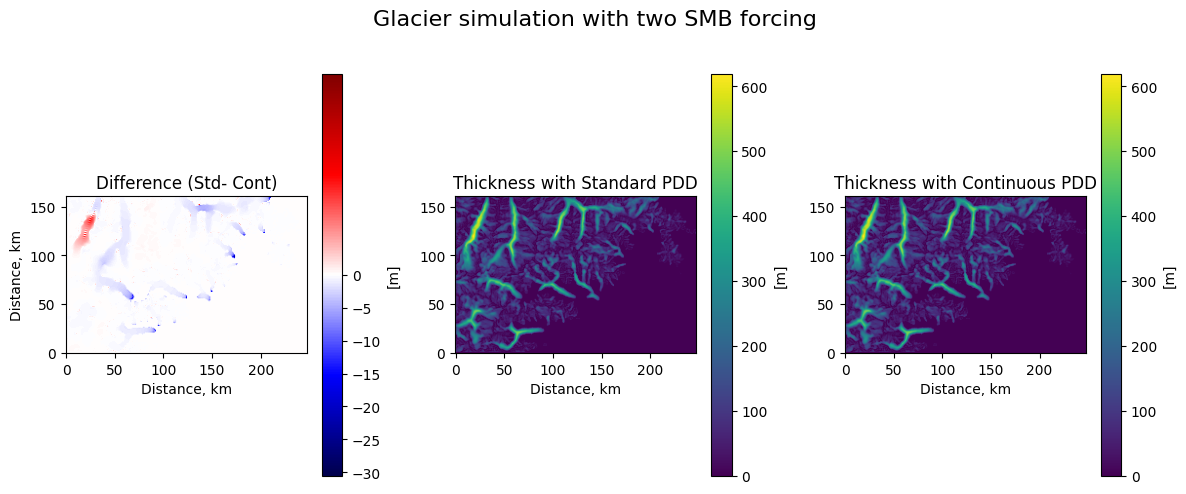

In [19]:
from matplotlib.colors import TwoSlopeNorm

# Convert tensors to numpy
run1_np = run1.detach().cpu().numpy()
run2_np = run2.detach().cpu().numpy()

# Calculate the difference
diff_np = run1_np - run2_np

# Create a figure with three subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Define the norm to center at 0 for custom blue-white-red mapping
vmin = np.min(diff_np)
vmax = np.max(diff_np)
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot the Difference with white at 0
im1 = ax[0].imshow(diff_np, cmap='seismic', norm=norm, origin='lower')
fig.colorbar(im1, ax=ax[0], orientation='vertical', label='[m]')
ax[0].set_title('Difference (Std- Cont)')
ax[0].set_xlabel('Distance, km')
ax[0].set_ylabel('Distance, km')

# Second subplot: Ice thickness (simulated)
im2 = ax[1].imshow(run2_np, origin='lower')
fig.colorbar(im2, ax=ax[1], orientation='vertical', label='[m]')
ax[1].set_title('Thickness with Standard PDD')
ax[1].set_xlabel('Distance, km')

# Third subplot: Observed ice thickness
im3 = ax[2].imshow(run1_np, origin='lower')
fig.colorbar(im3, ax=ax[2], orientation='vertical', label='[m]')
ax[2].set_title('Thickness with Continuous PDD')
ax[2].set_xlabel('Distance, km')

# Add a main title
fig.suptitle('Glacier simulation with two SMB forcing', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.savefig('Diffenrence_H.png')
# Display the plots
plt.show()

/tmp/ipykernel_83696/3861737552.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  smb1 = torch.load('smb1.pt').to(device)
/tmp/ipykernel_83696/3861737552.py:3: FutureWarni

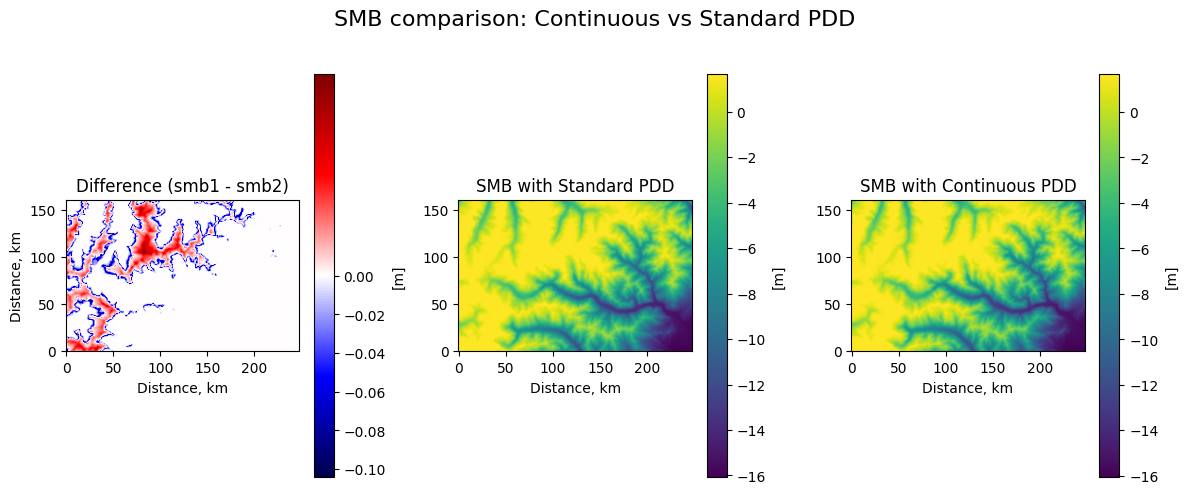

In [20]:
# Load SMB tensors
smb1 = torch.load('smb1.pt').to(device)
smb2 = torch.load('smb2.pt').to(device)

# Convert tensors to numpy
smb1_np = smb1.detach().cpu().numpy()
smb2_np = smb2.detach().cpu().numpy()

# Calculate the difference
diff_np = smb1_np - smb2_np

# Create a figure with three subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Define the norm to center at 0 for custom blue-white-red mapping
vmin = np.min(diff_np)
vmax = np.max(diff_np)
norm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# Plot the Difference with white at 0
im1 = ax[0].imshow(diff_np, cmap='seismic', norm=norm, origin='lower')
fig.colorbar(im1, ax=ax[0], orientation='vertical', label='[m]')
ax[0].set_title('Difference (smb1 - smb2)')
ax[0].set_xlabel('Distance, km')
ax[0].set_ylabel('Distance, km')

# Second subplot: SMB2
im2 = ax[1].imshow(smb2_np, origin='lower')
fig.colorbar(im2, ax=ax[1], orientation='vertical', label='[m]')
ax[1].set_title('SMB with Standard PDD')
ax[1].set_xlabel('Distance, km')

# Third subplot: SMB1
im3 = ax[2].imshow(smb1_np, origin='lower')
fig.colorbar(im3, ax=ax[2], orientation='vertical', label='[m]')
ax[2].set_title('SMB with Continuous PDD')
ax[2].set_xlabel('Distance, km')

# Add a main title
fig.suptitle('SMB comparison: Continuous vs Standard PDD', fontsize=16)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Save and display
plt.savefig('Difference_smb.png')
plt.show()